In [57]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [59]:
ticker = "AAPL"
df = yf.download(ticker, '2020-01-01')

C:\Users\olivi\AppData\Local\Temp\ipykernel_23136\843684142.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [60]:
df.tail()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-11-10,269.429993,273.730011,267.459991,268.959991,41312400
2025-11-11,275.250000,275.910004,269.799988,269.809998,46208300
2025-11-12,273.470001,275.730011,271.700012,275.000000,48398000
2025-11-13,272.950012,276.700012,272.089996,274.109985,49602800
2025-11-14,272.410004,275.959991,269.600006,271.049988,47399300


<Axes: xlabel='Date'>

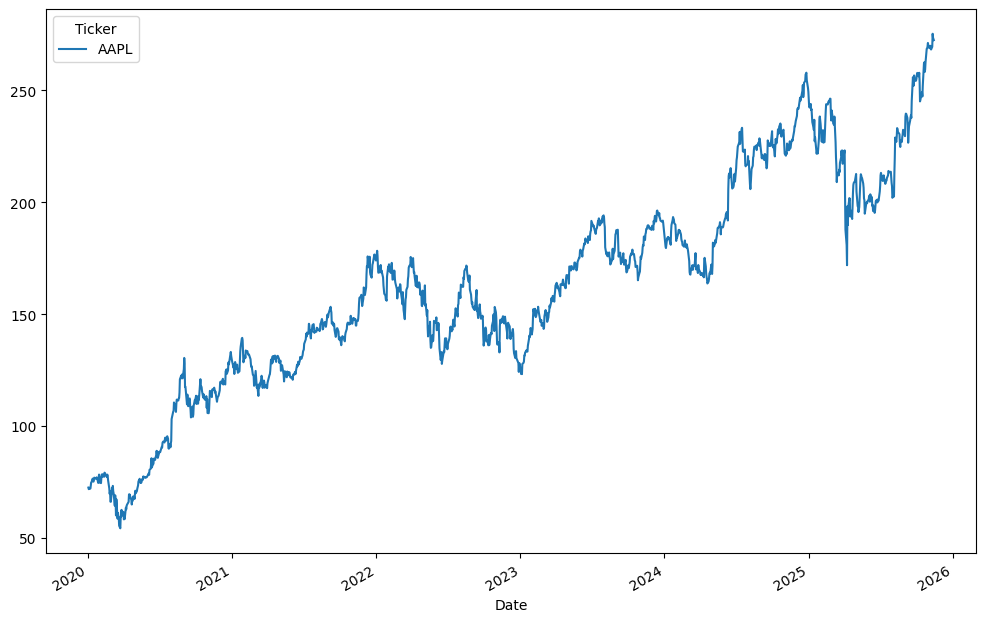

In [61]:
df.Close.plot(figsize=(12,8))

In [62]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df[['Close']])

In [63]:
df['Close'].head()

Ticker,AAPL
Date,
2020-01-02,-1.895926
2020-01-03,-1.910741
2020-01-06,-1.898717
2020-01-07,-1.905870
2020-01-08,-1.881517


In [64]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

In [65]:
train_size = int(len(data) * 0.8)
X_train = torch.from_numpy(data[:train_size, :-1,:]).type(torch.FloatTensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1,:]).type(torch.FloatTensor).to(device)

X_test = torch.from_numpy(data[train_size:, :-1,:]).type(torch.FloatTensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1,:]).type(torch.FloatTensor).to(device)

In [66]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [67]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [68]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 300

for epoch in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)
    
    if i % 25 == 0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [70]:
model.eval()

y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [71]:
train_rsme = mean_squared_error(y_train[:,0], y_train_pred[:,0])
test_rsme = mean_squared_error(y_test[:,0], y_test_pred[:,0])

In [72]:
train_rsme

3.1544339656829834

In [73]:
test_rsme

360.4587707519531

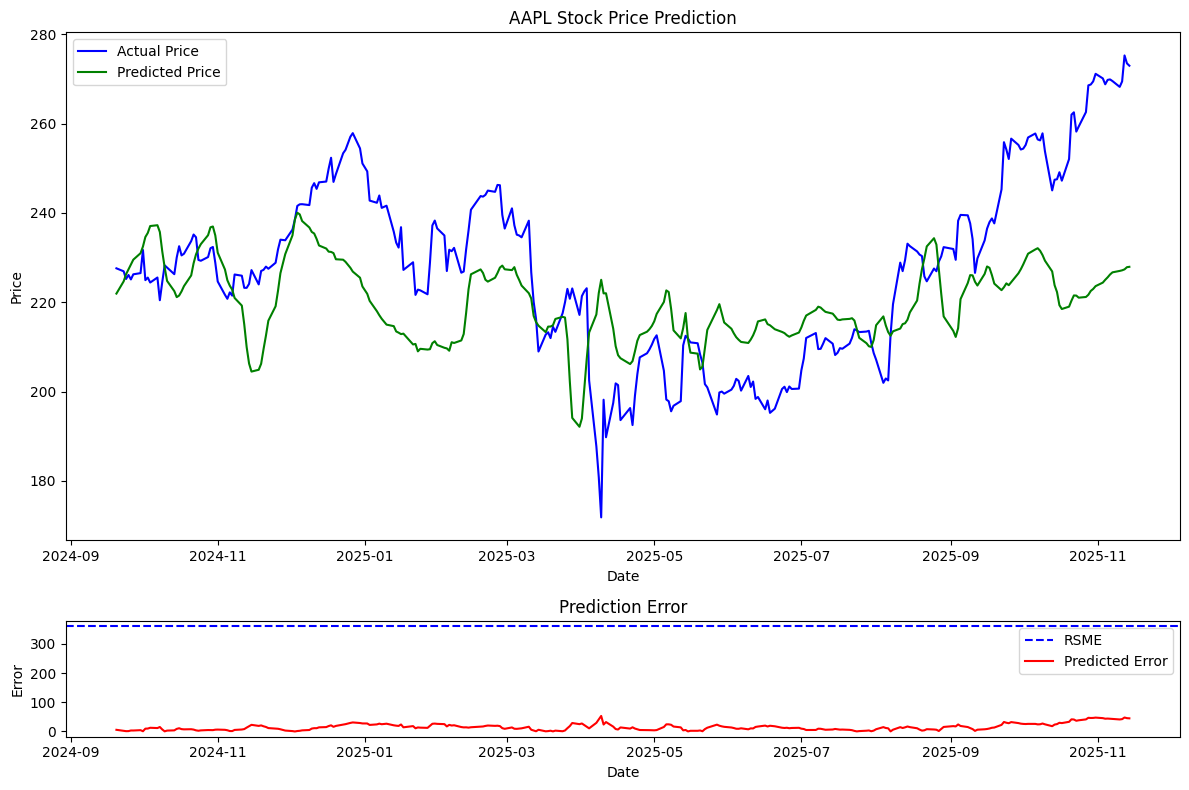

In [74]:
fig = plt.figure(figsize=(12,8))
gs = fig.add_gridspec(4,1)
ax1 = fig.add_subplot(gs[:3,0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color='blue', label='Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color='green', label='Predicted Price')   
ax1.legend()
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3,0])
ax2.axhline(test_rsme, color='blue', linestyle='--', label='RSME')
ax2.plot(df.iloc[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label='Predicted Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')

plt.tight_layout()
plt.show()